Data_collect_real: 6105 images
Data_collect_fake: 6016 images


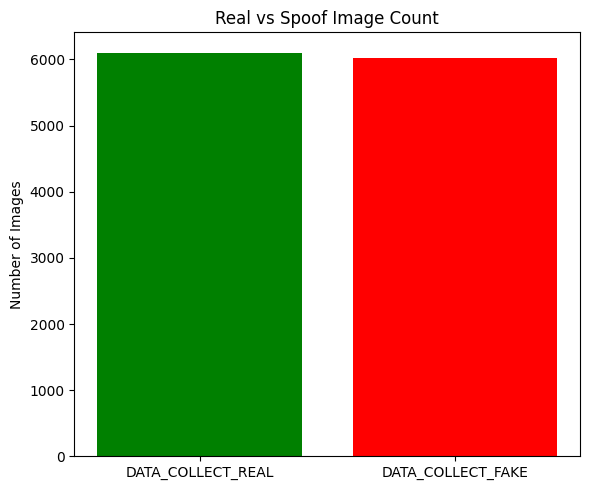

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt

# === CONFIG ===
DATASET_DIR = Path("E:/STUDIES/Prj/Anti_Spoof/DATA_COLLECT")  # Change this to your dataset path
FOLDERS = ['DATA_COLLECT_REAL', 'DATA_COLLECT_FAKE']
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png'}

def count_images(folder_path):
    return len([f for f in folder_path.iterdir() if f.suffix.lower() in IMAGE_EXTENSIONS])

def main():
    counts = {}
    for folder in FOLDERS:
        folder_path = DATASET_DIR / folder
        if not folder_path.exists():
            print(f"[!] Folder not found: {folder_path}")
            counts[folder] = 0
        else:
            count = count_images(folder_path)
            counts[folder] = count
            print(f"{folder.capitalize():<5}: {count} images")

    # Plot
    plt.figure(figsize=(6, 5))
    plt.bar(counts.keys(), counts.values(), color=['green', 'red'])
    plt.title("Real vs Spoof Image Count")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Data_collect_real: 6105 labels
Data_collect_fake: 6016 labels


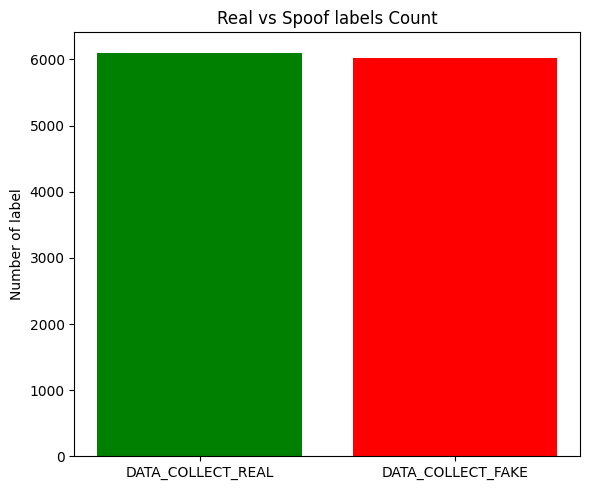

In [7]:
from pathlib import Path
import matplotlib.pyplot as plt

# === CONFIG ===
DATASET_DIR = Path("E:/STUDIES/Prj/Anti_Spoof/DATA_COLLECT")  # Change this to your dataset path
FOLDERS = ['DATA_COLLECT_REAL', 'DATA_COLLECT_FAKE']
IMAGE_EXTENSIONS = {'.txt'}

def count_images(folder_path):
    return len([f for f in folder_path.iterdir() if f.suffix.lower() in IMAGE_EXTENSIONS])

def main():
    counts = {}
    for folder in FOLDERS:
        folder_path = DATASET_DIR / folder
        if not folder_path.exists():
            print(f"[!] Folder not found: {folder_path}")
            counts[folder] = 0
        else:
            count = count_images(folder_path)
            counts[folder] = count
            print(f"{folder.capitalize():<5}: {count} labels")

    # Plot
    plt.figure(figsize=(6, 5))
    plt.bar(counts.keys(), counts.values(), color=['green', 'red'])
    plt.title("Real vs Spoof labels Count")
    plt.ylabel("Number of label")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [1]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Point to the original folders
real_folder = "E:/STUDIES/Prj/Anti_Spoof/DATASET/REAL"
spoof_folder = "E:/STUDIES/Prj/Anti_Spoof/DATASET/SPOOF"
outputFolderPath = "E:/STUDIES/Prj/Anti_Spoof/DATASET/Split_Data1"
splitRatio = {"train": 0.7, "val": 0.2, "test": 0.1}
classes = ["fake", "real"]

# Step 1: Collect data from original folders
data_pairs = []

for file in os.listdir(real_folder):
    if file.endswith(".txt"):
        basename = file[:-4]
        data_pairs.append((basename, 1))  # real = 1

for file in os.listdir(spoof_folder):
    if file.endswith(".txt"):
        basename = file[:-4]
        data_pairs.append((basename, 0))  # spoof = 0

# Shuffle & stratified split
names = [name for name, _ in data_pairs]
labels = [label for _, label in data_pairs]

train_names, temp_names, train_labels, temp_labels = train_test_split(
    names, labels, test_size=(1 - splitRatio["train"]), stratify=labels, random_state=42)

val_ratio = splitRatio["val"] / (splitRatio["val"] + splitRatio["test"])
val_names, test_names, _, _ = train_test_split(
    temp_names, temp_labels, test_size=(1 - val_ratio), stratify=temp_labels, random_state=42)

splits = {
    "train": train_names,
    "val": val_names,
    "test": test_names
}

# Step 2: Copy the files from original folders
if os.path.exists(outputFolderPath):
    shutil.rmtree(outputFolderPath)

for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(outputFolderPath, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(outputFolderPath, split, 'labels'), exist_ok=True)

# Helper: where is each file originally from?
source_lookup = {}
for f in os.listdir(real_folder):
    if f.endswith(".jpg"):
        source_lookup[f[:-4]] = real_folder
for f in os.listdir(spoof_folder):
    if f.endswith(".jpg"):
        source_lookup[f[:-4]] = spoof_folder

# Now copy
for split, name_list in splits.items():
    for name in name_list:
        folder = source_lookup.get(name)
        if folder:
            img_src = os.path.join(folder, f"{name}.jpg")
            txt_src = os.path.join(folder, f"{name}.txt")
            img_dst = os.path.join(outputFolderPath, split, "images", f"{name}.jpg")
            txt_dst = os.path.join(outputFolderPath, split, "labels", f"{name}.txt")
            if os.path.exists(img_src) and os.path.exists(txt_src):
                shutil.copy(img_src, img_dst)
                shutil.copy(txt_src, txt_dst)

# Step 3: Write data.yaml
yaml_content = f"""path: .
train: train/images
val: val/images
test: test/images

nc: {len(classes)}
names: {classes}
"""

with open(os.path.join(outputFolderPath, "data.yaml"), "w") as f:
    f.write(yaml_content)

print("✅ Split complete using original class folders.")


✅ Split complete using original class folders.


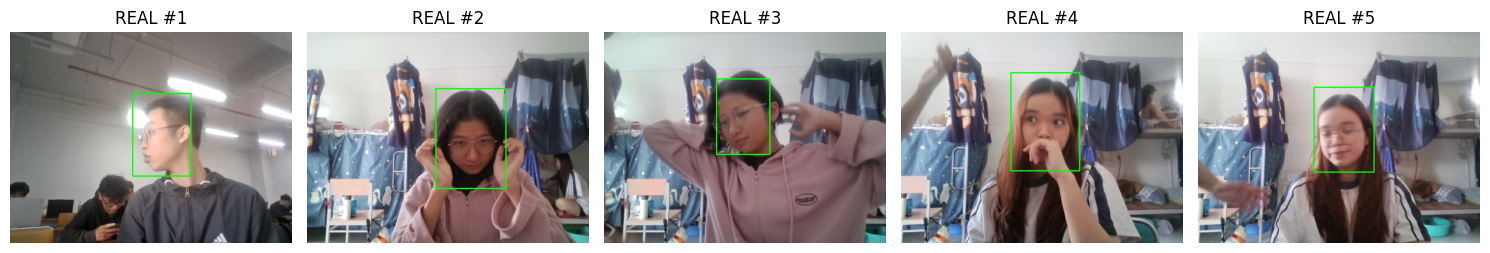

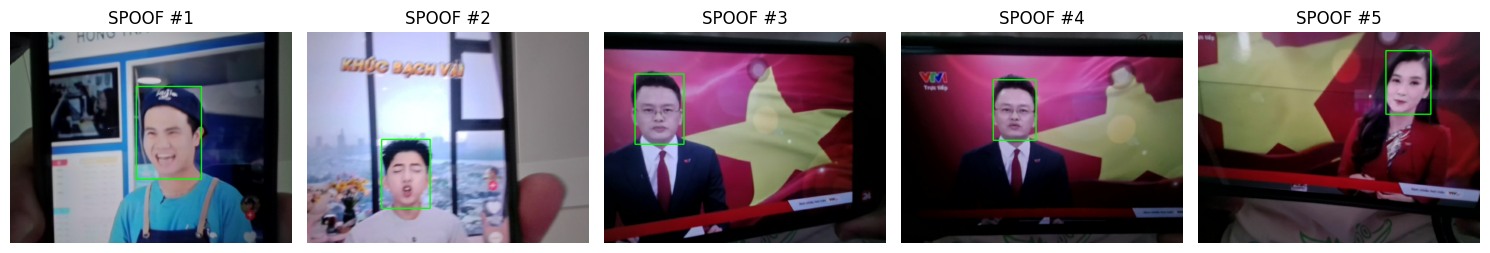

In [4]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# === CONFIG ===
real_dir = "E:/STUDIES/Prj/Anti_Spoof/DATA_COLLECT/DATA_COLLECT_REAL"
spoof_dir = "E:/STUDIES/Prj/Anti_Spoof/DATA_COLLECT/DATA_COLLECT_FAKE"
num_samples = 5  # number of samples per class to visualize
show_bbox = True  # set to False if you don't want bounding boxes

# === HELPER FUNCTION ===
def load_and_plot_samples(folder, title, n):
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    sampled_files = random.sample(image_files, min(n, len(image_files)))

    plt.figure(figsize=(15, 5))
    for idx, img_file in enumerate(sampled_files):
        img_path = os.path.join(folder, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Draw bounding boxes if available
        if show_bbox:
            label_path = os.path.join(folder, os.path.splitext(img_file)[0] + ".txt")
            h, w = image.shape[:2]
            if os.path.exists(label_path):
                with open(label_path, "r") as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) == 5:
                            _, cx, cy, bw, bh = map(float, parts)
                            x1 = int((cx - bw / 2) * w)
                            y1 = int((cy - bh / 2) * h)
                            x2 = int((cx + bw / 2) * w)
                            y2 = int((cy + bh / 2) * h)
                            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        plt.subplot(1, n, idx + 1)
        plt.imshow(image)
        plt.title(f"{title} #{idx+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# === VISUALIZE ===
load_and_plot_samples(real_dir, "REAL", num_samples)
load_and_plot_samples(spoof_dir, "SPOOF", num_samples)



-- TRAIN SET --
  Real Faces : 4599
  Spoof Faces: 4711

-- VAL SET --
  Real Faces : 1316
  Spoof Faces: 1358

-- TEST SET --
  Real Faces : 649
  Spoof Faces: 665


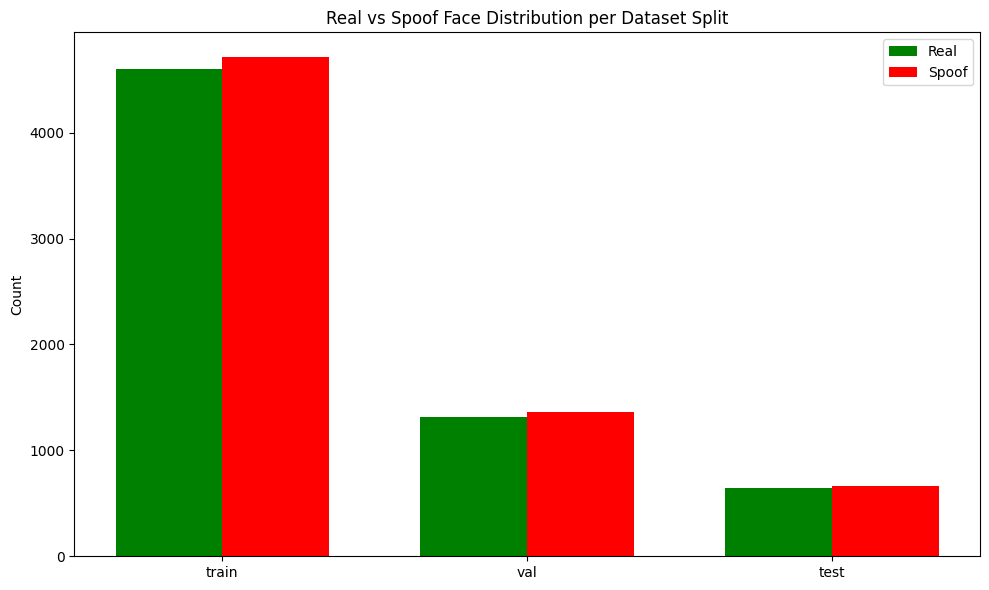

In [2]:
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt

# === CONFIG ===
BASE_PATH = Path("E:/STUDIES/Prj/Anti_Spoof/DATASET/Split_Data")  # Change this to your dataset root
SPLITS = ['train', 'val', 'test']
LABEL_DIR_NAME = 'labels'  # Folder name containing label .txt files

def count_labels(label_dir: Path):
    counts = defaultdict(int)

    for label_file in label_dir.glob("*.txt"):
        with open(label_file, 'r') as f:
            for line in f:
                if not line.strip():
                    continue
                class_id = line.strip().split()[0]
                if class_id == '0':
                    counts['spoof'] += 1
                elif class_id == '1':
                    counts['real'] += 1
    return counts

def analyze_all_splits(base_path):
    summary = {}
    for split in SPLITS:
        label_path = base_path / split / LABEL_DIR_NAME
        if not label_path.exists():
            print(f"[!] Missing label folder: {label_path}")
            continue
        print(f"\n-- {split.upper()} SET --")
        counts = count_labels(label_path)
        print(f"  Real Faces : {counts['real']}")
        print(f"  Spoof Faces: {counts['spoof']}")
        summary[split] = counts
    return summary

def plot_summary(summary):
    splits = list(summary.keys())
    real_counts = [summary[split]['real'] for split in splits]
    spoof_counts = [summary[split]['spoof'] for split in splits]

    x = range(len(splits))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar([i - width/2 for i in x], real_counts, width=width, label='Real', color='green')
    plt.bar([i + width/2 for i in x], spoof_counts, width=width, label='Spoof', color='red')

    plt.xticks(x, splits)
    plt.ylabel('Count')
    plt.title('Real vs Spoof Face Distribution per Dataset Split')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    summary = analyze_all_splits(BASE_PATH)
    plot_summary(summary)
